In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STGCN-PyTorch

## Packages

In [ ]:
!pip install tabulate

/bin/bash: /home/alberto/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import random
import torch
import copy
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tabulate import tabulate

## Load data

In [ ]:

def load_matrix(file_path):
  return pd.read_csv(file_path, header=None, skiprows=1).values.astype(float)

def load_data(file_path, len_train, len_val):
    df = pd.read_csv(file_path, header=0).drop(['year'], axis=1).values.astype(float)
    train = df[: len_train]
    val = df[len_train: len_train + len_val]
    test = df[len_train + len_val:]
    return train, val, test

"""
# Version 1
def data_transform(data, device):
    n_year = data.shape[0]  # Número de años
    n_route = data.shape[1]  # Número de rutas

    x = np.zeros([n_year, 1, 1, n_route])  # La dimensión 1 en x representa el tiempo, pero como solo hay un dato por año, es 1.
    y = np.zeros([n_year, n_route])

    for i in range(n_year):
        x[i, 0, 0, :] = data[i]  # Para cada año, el único dato se coloca en x
        y[i] = data[i]  # La salida y es simplemente el mismo dato

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)
"""
# Version 2
def data_transform(data, n_his, n_pred, device):
    n_year = data.shape[0]
    n_route = data.shape[1]
    n_slot = n_year - n_his - n_pred + 1

    x = np.zeros([n_slot, 1, n_his, n_route])
    y = np.zeros([n_slot, n_route])
    for i in range(n_slot):
        x[i, :, :, :] = data[i:i + n_his].reshape(1, n_his, n_route)
        y[i] = data[i + n_his + n_pred - 1]
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

def data_transform_explore(data, n_his, n_pred, device):
    n_year = data.shape[0]
    n_route = data.shape[1]
    n_slot = n_year - n_his - n_pred + 1

    x = np.zeros([n_slot, 1, n_his, n_route])
    y = np.zeros([n_slot, n_route])
    for i in range(n_slot):
        x[i, :, :, :] = data[i:i + n_his].reshape(1, n_his, n_route)
        y[i] = data[i + n_his + n_pred - 1]
    # return x, y
    return torch.tensor(x, dtype=torch.double).to(device), torch.tensor(y, dtype=torch.double).to(device)

def calculate_adjacency_matrix(distances, sigma_squared=10, epsilon=0.5):
  """
  Calcula la matriz de adyacencia ponderada W basada en las distancias entre estaciones.
  Args:
  distances (np.ndarray): Matriz de distancias entre estaciones de forma (N, N).
  sigma_squared (float): Valor de sigma al cuadrado para el cálculo de los pesos.
  epsilon (float): Umbral para determinar si un peso es suficiente para ser incluido en la matriz.
  Returns:
  np.ndarray: Matriz de adyacencia ponderada W.
  """
  N = distances.shape[0]
  W = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if i != j:
        weight = np.exp(-distances[i, j]**2 / sigma_squared)
        if weight >= epsilon:
          W[i, j] = weight

  return W

def calcular_matriz_adyacencia(df_distancias, sigma_squared = 10, epsilon = 0.5):
    """
    Calcula la matriz de adyacencia ponderada W basada en las distancias entre estaciones.
    Args:
    df_distancias (pd.DataFrame): DataFrame de distancias entre estaciones.
    sigma_squared (float): Valor de sigma al cuadrado para el cálculo de los pesos.
    epsilon (float): Umbral para determinar si un peso es suficiente para ser incluido en la matriz.
    Returns:
    pd.DataFrame: DataFrame de la matriz de adyacencia ponderada W.
    """
    # Convertir el DataFrame de distancias a una matriz numpy
    distances = df_distancias.values

    N = distances.shape[0]
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                weight = np.exp(-distances[i, j]**2 / sigma_squared)
                if weight >= epsilon:
                    W[i, j] = weight

    # Convertir la matriz W de numpy a un DataFrame de pandas
    df_W = pd.DataFrame(W, index=df_distancias.index, columns=df_distancias.columns)
    return df_W

## stgcn

#### Original

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class align(nn.Module):
    def __init__(self, c_in, c_out):
        super(align, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        if c_in > c_out:
            self.conv1x1 = nn.Conv2d(c_in, c_out, 1)

    def forward(self, x):
        if self.c_in > self.c_out:
            return self.conv1x1(x)
        if self.c_in < self.c_out:
            return F.pad(x, [0, 0, 0, 0, 0, self.c_out - self.c_in, 0, 0])
        return x

class temporal_conv_layer(nn.Module):
    def __init__(self, kt, c_in, c_out, act="relu"):
        super(temporal_conv_layer, self).__init__()
        self.kt = kt
        self.act = act
        self.c_out = c_out
        self.align = align(c_in, c_out)
        if self.act == "GLU":
            self.conv = nn.Conv2d(c_in, c_out * 2, (kt, 1), 1)
        else:
            self.conv = nn.Conv2d(c_in, c_out, (kt, 1), 1)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.conv.weight, a=math.sqrt(5))
        if self.conv.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.conv.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.conv.bias, -bound, bound)

    def forward(self, x):
        x_in = self.align(x)[:, :, self.kt - 1:, :]
        if self.act == "GLU":
            x_conv = self.conv(x)
            return (x_conv[:, :self.c_out, :, :] + x_in) * torch.sigmoid(x_conv[:, self.c_out:, :, :])
        if self.act == "sigmoid":
            return torch.sigmoid(self.conv(x) + x_in)
        return torch.relu(self.conv(x) + x_in)

class spatio_conv_layer(nn.Module):
    def __init__(self, ks, c, Lk):
        super(spatio_conv_layer, self).__init__()
        self.Lk = Lk
        self.theta = nn.Parameter(torch.FloatTensor(c, c, ks))
        self.b = nn.Parameter(torch.FloatTensor(1, c, 1, 1))
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.theta, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.theta)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.b, -bound, bound)

    def forward(self, x):
        x_c = torch.einsum("knm,bitm->bitkn", self.Lk, x)
        x_gc = torch.einsum("iok,bitkn->botn", self.theta, x_c) + self.b
        return torch.relu(x_gc + x)

class st_conv_block(nn.Module):
    def __init__(self, ks, kt, n, c, p, Lk):
        super(st_conv_block, self).__init__()
        self.tconv1 = temporal_conv_layer(kt, c[0], c[1], "GLU")
        self.sconv = spatio_conv_layer(ks, c[1], Lk)
        self.tconv2 = temporal_conv_layer(kt, c[1], c[2])
        self.ln = nn.LayerNorm([n, c[2]])
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_s = self.sconv(x_t1)
        x_t2 = self.tconv2(x_s)
        x_ln = self.ln(x_t2.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        return self.dropout(x_ln)

class fully_conv_layer(nn.Module):
    def __init__(self, c):
        super(fully_conv_layer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.conv.weight, a=math.sqrt(5))
        if self.conv.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.conv.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.conv.bias, -bound, bound)

    def forward(self, x):
        return self.conv(x)

class output_layer(nn.Module):
    def __init__(self, c, T, n):
        super(output_layer, self).__init__()
        self.tconv1 = temporal_conv_layer(T, c, c, "GLU")
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = temporal_conv_layer(1, c, c, "sigmoid")
        self.fc = fully_conv_layer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN(nn.Module):
    def __init__(self, ks, kt, bs, T, n, Lk, p):
        super(STGCN, self).__init__()
        # torch.manual_seed(2333)  # Reiniciar semilla para cada instancia
        # torch.cuda.manual_seed(2333)
        # np.random.seed(2333)
        # random.seed(2333)
        # torch.backends.cudnn.deterministic = True

        self.st_conv1 = st_conv_block(ks, kt, n, bs[0], p, Lk)
        self.st_conv2 = st_conv_block(ks, kt, n, bs[1], p, Lk)
        self.output = output_layer(bs[1][2], T - 4 * (kt - 1), n)

    def forward(self, x):
        x_st1 = self.st_conv1(x)
        x_st2 = self.st_conv2(x_st1)
        return self.output(x_st2)


#### Pytorch

In [ ]:
!pip install torch_geometric

/bin/bash: /home/alberto/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv


class TemporalConv(nn.Module):
    r"""Temporal convolution block applied to nodes in the STGCN Layer
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting."
    <https://arxiv.org/abs/1709.04875>`_ Based off the temporal convolution
     introduced in "Convolutional Sequence to Sequence Learning"  <https://arxiv.org/abs/1709.04875>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H


class STConv(nn.Module):
    r"""Spatio-temporal convolution block using ChebConv Graph Convolutions.
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting"
    <https://arxiv.org/abs/1709.04875>`_

    NB. The ST-Conv block contains two temporal convolutions (TemporalConv)
    with kernel size k. Hence for an input sequence of length m,
    the output sequence will be length m-2(k-1).

    Args:
        in_channels (int): Number of input features.
        hidden_channels (int): Number of hidden units output by graph convolution block
        out_channels (int): Number of output features.
        kernel_size (int): Size of the kernel considered.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)

    """

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConv, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        T = T.permute(0, 2, 1, 3)
        T = self._batch_norm(T)
        T = T.permute(0, 2, 1, 3)
        return T

## Utils

In [ ]:
import torch
import numpy as np

def scaled_laplacian(A):
    n = A.shape[0]
    d = np.sum(A, axis=1)
    L = np.diag(d) - A
    for i in range(n):
        for j in range(n):
            if d[i] > 0 and d[j] > 0:
                L[i, j] /= np.sqrt(d[i] * d[j])
    lam = np.linalg.eigvals(L).max().real
    return 2 * L / lam - np.eye(n)


def cheb_poly(L, Ks):
    n = L.shape[0]
    LL = [np.eye(n), L[:]]
    for i in range(2, Ks):
        LL.append(np.matmul(2 * L, LL[-1]) - LL[-2])
    return np.asarray(LL)

"""
def evaluate_model(model, loss, data_iter):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            l = loss(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n
"""
# Definición de la función para calcular el RMSE con datos desescalados
def evaluate_model(model, loss_fn, data_iter, scaler):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            # Desescalar las predicciones y los valores reales
            y = torch.tensor(scaler.inverse_transform(y.cpu().numpy()), dtype=torch.float32).to(y.device)
            y_pred = torch.tensor(scaler.inverse_transform(y_pred.cpu().numpy()), dtype=torch.float32).to(y.device)
            l = loss_fn(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
    return l_sum / n

def evaluate_metric(model, data_iter, scaler):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()  # En las mismas unidades que los datos originales
        MAPE = np.array(mape).mean() * 100  # Convertir a porcentaje
        RMSE = np.sqrt(np.array(mse).mean())  # En las mismas unidades que los datos originales
        return MAE, MAPE, RMSE
"""

def evaluate_metric(model, data_iter, scaler):
    model.eval()
    criterion = torch.nn.L1Loss()  # Para calcular MAE
    mse_loss = torch.nn.MSELoss()  # Para calcular MSE
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)

            # Calcular MAE usando PyTorch
            y_tensor = torch.tensor(y, dtype=torch.float32)
            y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
            mae_loss = criterion(y_pred_tensor, y_tensor)
            mae.append(mae_loss.item())

            # Calcular MAPE manualmente
            d = np.abs(y - y_pred)
            mape.append(np.abs((d / y).mean()))

            # Calcular MSE usando PyTorch y luego RMSE
            mse_loss_val = mse_loss(y_pred_tensor, y_tensor)
            mse.append(mse_loss_val.item())

        MAE = np.mean(mae)  # En las mismas unidades que los datos originales
        MAPE = np.mean(mape) * 100  # Convertir a porcentaje
        RMSE = np.sqrt(np.mean(mse))  # En las mismas unidades que los datos originales

        return MAE, MAPE, RMSE
"""
def find_min_max_in_iter(data_iter):
    """
    Encuentra los valores mínimo y máximo de y en un iterable de datos.

    Parámetros:
    - data_iter: Un iterable (como un DataLoader) que proporciona lotes de datos (x, y).

    Retorna:
    - El valor mínimo y el valor máximo en y a lo largo de todos los lotes en data_iter.
    """
    y_min = float('inf')
    y_max = float('-inf')

    for _, y in data_iter:
        batch_min = torch.min(y)
        batch_max = torch.max(y)

        if batch_min < y_min:
            y_min = batch_min.item()

        if batch_max > y_max:
            y_max = batch_max.item()

    return y_min, y_max

## Random Seed

In [ ]:
torch.manual_seed(2333)
torch.cuda.manual_seed(2333)
np.random.seed(2333)
random.seed(2333)
torch.backends.cudnn.deterministic = True

## Device

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## File Path

In [ ]:
from datetime import datetime

def generate_id():
    now = datetime.now()
    id_str = now.strftime("%Y%m%d%H%M%S%f")  # Formatea la fecha y hora con microsegundos
    return id_str

In [ ]:
drive = False
if (drive):
    matrix_path = '/content/drive/My Drive/TFM/data/countries_W.csv'
    data_path = '/content/drive/My Drive/TFM/data/countries_V.csv'
    save_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:10]}.pth'
else:
    main_dir = os.getcwd()
    data_dir = os.path.join(main_dir, "data")

    matrix_path = os.path.join(data_dir, 'countries_W.csv')
    data_path = os.path.join(data_dir, 'countries_V.csv')
    save_path = os.path.join(main_dir, "models", f'model-{generate_id()[:10]}.pth')

#### Initial Data Presentation

In [ ]:
# countries_W : Distancia entre países (Km)
# [N paises]x[N paises]
matrix_df = pd.read_csv(matrix_path)
matrix_df.head()

,AFG,AGO,ALB,ARG,AUS,AUT,BDI,BEL,BEN,BFA,...,TWN,UGA,URY,USA,VEN,VNM,VUT,WSM,YEM,ZAF
0,90.264152,7563.813745,4243.150201,15333.278441,11020.750969,4557.808571,5842.157165,5326.836645,7323.327350,7456.055883,...,5182.340920,5297.469811,14997.550961,11576.604432,13216.759733,4474.746533,11957.735092,13610.205117,3265.185468,8308.032937
1,7563.813501,67.455484,5699.611253,7961.882044,12879.337364,6423.483550,1888.743190,6809.597763,2307.673135,3008.166199,...,12196.273350,2367.616480,7571.737283,11972.143872,9285.623475,10596.504073,15901.561135,17323.951630,4329.462461,2538.541629
2,4243.150158,5699.611363,51.529788,11655.905498,15152.402953,840.694865,5048.706435,1606.491842,4097.628784,3872.137252,...,9136.222717,4676.669984,11430.069292,8710.583375,9079.924715,8719.470898,15972.657454,16786.036351,3796.269625,7839.691024
3,15333.278882,7961.882510,11655.905388,96.149337,12018.272985,11742.894606,9824.102613,11297.558182,8038.747870,7978.479089,...,18949.552626,10329.289501,308.492068,8608.022038,4852.384377,17513.163003,12414.300116,11055.515675,12267.062829,8024.234046
4,11020.750741,12879.337827,15152.402925,12018.272781,153.628704,15559.910589,12045.124538,16277.454792,15161.884522,15855.484168,...,6982.515206,12061.033070,12069.768153,14589.168108,15625.261129,6690.733214,2763.163848,4724.266225,11809.683663,10412.115536


In [ ]:
df_adyacencia = calcular_matriz_adyacencia(matrix_df)
df_adyacencia.head()

,AFG,AGO,ALB,ARG,AUS,AUT,BDI,BEL,BEN,BFA,...,TWN,UGA,URY,USA,VEN,VNM,VUT,WSM,YEM,ZAF
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# [N años]x[N paises x N paises]
data_df = pd.read_csv(data_path)
data_df

,year,COM,GUY,LBR,SEN,BRN,JPN,USA,RUS,OMN,...,IRL,SUR,BEN,COG,FIN,TUR,GBR,NOR,NIC,CYP
0,1962,-0.344110,0.068288,-0.442236,-0.203830,0.193716,2.091124,2.072395,0.535564,0.003049,...,1.172661,-0.182548,0.062017,-0.865575,1.125539,-0.704393,2.288769,1.365959,-1.075753,0.000652
1,1963,-0.138500,-0.112739,-0.764035,-0.198813,-1.363110,1.917151,2.034126,0.316475,0.837160,...,1.008410,-0.267773,0.264796,-0.654586,1.375939,-0.769430,2.278447,1.231053,-1.057869,-0.131323
2,1964,-1.421275,-0.130738,-0.604106,-0.484891,-0.469227,1.895972,2.039541,0.726326,-0.868269,...,1.194336,-0.909445,0.085699,-1.230536,1.293779,-0.601434,2.227930,1.321681,-0.222088,-0.344254
3,1965,-1.312219,-0.209335,-0.565352,-0.422038,-1.309534,1.944695,2.066791,0.723283,-0.834009,...,1.258328,-0.280529,-0.100788,-0.824339,1.331217,-0.715468,2.347121,1.216481,0.143597,-0.492979
4,1966,-1.334038,-0.376698,-0.523193,-0.147933,-0.461554,1.881980,2.018157,0.638421,-0.669928,...,1.140344,-0.320551,-0.284729,-1.181578,1.468790,-0.682230,2.279568,1.301043,0.177704,-0.234378
5,1967,-0.493923,-0.291020,-0.771450,-0.368112,-0.259950,1.878785,1.963492,0.573210,-1.269138,...,1.103829,-0.497721,-0.630330,-0.970413,1.455478,-0.683027,2.170976,1.339392,0.162187,-0.218237
6,1968,-1.103797,-0.344747,-0.974225,-0.380494,-1.080477,1.844871,1.957765,0.429629,-1.563003,...,1.054101,-0.432282,-0.820837,-1.061545,1.401928,-0.654802,2.058025,1.258037,0.141456,-0.154697
7,1969,-1.004615,-0.511678,-1.208411,-0.050650,-0.800159,1.929652,1.909767,0.332692,-1.422010,...,1.019945,-0.498614,-0.830430,-1.051724,1.489982,-0.582622,2.109727,1.357857,0.023059,-0.157489
8,1970,1.213423,-0.000075,-0.578339,-0.160236,-0.916049,1.933674,1.792584,0.554691,-1.025302,...,1.011404,-0.405132,-0.726854,-1.209213,1.458573,-0.540301,2.096027,1.229038,0.156778,-0.031623
9,1971,-0.933597,0.006441,-0.877289,-0.100347,-0.394928,1.862756,1.873357,0.420006,-1.415142,...,1.089522,-0.266790,-0.779061,-0.941122,1.382261,-0.443655,2.164667,1.297569,0.216787,0.266353


In [ ]:
df = pd.read_csv(data_path, usecols=range(9))

# Mostrar las primeras filas del DataFrame resultante
df.head()

,year,COM,GUY,LBR,SEN,BRN,JPN,USA,RUS
0,1962,-0.344110,0.068288,-0.442236,-0.203830,0.193716,2.091124,2.072395,0.535564
1,1963,-0.138500,-0.112739,-0.764035,-0.198813,-1.363110,1.917151,2.034126,0.316475
2,1964,-1.421275,-0.130738,-0.604106,-0.484891,-0.469227,1.895972,2.039541,0.726326
3,1965,-1.312219,-0.209335,-0.565352,-0.422038,-1.309534,1.944695,2.066791,0.723283
4,1966,-1.334038,-0.376698,-0.523193,-0.147933,-0.461554,1.881980,2.018157,0.638421


 #### SITC Origina Data

In [ ]:
stata_file_path = os.path.join(data_dir, 'country_partner_sitcproduct2digit_year.dta')

In [ ]:
df = pd.read_stata(stata_file_path).head()
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,1,102,2018.0,27560.0,0.0,0.800212,0.174964,ABW,AFG,02
1,0,1,102,2019.0,51178.0,0.0,0.935727,-0.282090,ABW,AFG,02
2,7,1,102,2013.0,5530393.0,7302.0,-0.338417,-0.754102,ARE,AFG,02
3,7,1,102,2019.0,3661820.0,0.0,0.321754,0.026674,ARE,AFG,02
4,7,1,102,2021.0,1304571.0,0.0,0.124103,0.087807,ARE,AFG,02


## Parameters

In [ ]:
# Arquitecture params
day_slot = 114
n_train, n_val = 35, 12

n_his = 10
n_pred = 2
n_route = pd.read_csv(matrix_path).shape[1]
Ks, Kt = 4, 3
blocks = [[1, 512, 1024], [1024, 1024, 2048]]
drop_prob = 0

In [ ]:
# Training params
batch_size = 128
epochs = 50
lr = 1e-2

## Graph

In [ ]:
W = load_matrix(matrix_path)
L = scaled_laplacian(W)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

In [ ]:
W = np.random.rand(131, 131)
W = np.ones((131, 131))
# W = np.full((131, 131), 9200000)
# W = np.zeros((131, 131))
# Establecer los valores de la diagonal en 0
np.fill_diagonal(W, 0)

L = scaled_laplacian(W)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

In [ ]:
# Invertir cada valor de W
"""
L = np.reciprocal(L)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)
"""

'\nL = np.reciprocal(L)\nLk = cheb_poly(L, Ks)\nLk = torch.Tensor(Lk.astype(np.float32)).to(device)\n'

In [ ]:
# Invertir exponencialmente

L = calculate_adjacency_matrix(L)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

In [ ]:
L

array([[0.        , 0.99997669, 0.99997669, ..., 0.99997669, 0.99997669,
        0.99997669],
       [0.99997669, 0.        , 0.99997669, ..., 0.99997669, 0.99997669,
        0.99997669],
       [0.99997669, 0.99997669, 0.        , ..., 0.99997669, 0.99997669,
        0.99997669],
       ...,
       [0.99997669, 0.99997669, 0.99997669, ..., 0.        , 0.99997669,
        0.99997669],
       [0.99997669, 0.99997669, 0.99997669, ..., 0.99997669, 0.        ,
        0.99997669],
       [0.99997669, 0.99997669, 0.99997669, ..., 0.99997669, 0.99997669,
        0.        ]])

# Training & Save Model

## Data Loading

### Standardization

In [ ]:
train_df, val_df, test_df = load_data(data_path, n_train , n_val)
scaler = StandardScaler()
train = scaler.fit_transform(train_df)
val = scaler.transform(val_df)
test = scaler.transform(test_df)

### Transform Data

In [ ]:
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([24, 1, 10, 131])
torch.Size([24, 131])
torch.Size([1, 1, 10, 131])
torch.Size([1, 131])
torch.Size([2, 1, 10, 131])
torch.Size([2, 131])


### DataLoader

In [ ]:
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=False)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size, shuffle=False)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

## Loss & Model & Optimizer

In [ ]:
lr= 0.01

loss = nn.MSELoss()
model = STGCN(Ks, Kt, blocks, n_his, n_route, Lk, drop_prob).to(device)
            # ks, kt, bs,     T,     n,       Lk, p):
# Definir los optimizadores en un diccionario
optimizers = {
    "RMSprop" : torch.optim.RMSprop(model.parameters(), lr=lr), # RMSprop
    "AdamW" : torch.optim.AdamW(model.parameters(), lr=lr)    # AdamW
}

# Seleccionar el optimizador basado en el índice
optimizer_index = "RMSprop"
optimizer = optimizers[optimizer_index]

### LR Scheduler

In [ ]:
epochs = 300

In [ ]:
schedulers = {
    "StepLR": torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6), # Step Decay
    "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99), # Exponential Decay
    "CosineAnnealingLR": torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)  # Cosine Annealing
}

# Elegir el scheduler basado en el índice
scheduler_index = "CosineAnnealingLR"
scheduler = schedulers[scheduler_index]

## Training

In [ ]:
# Inicializar variables
min_val_loss = np.inf
min_train_loss = np.inf
best_epoch_val = 0
best_epoch_train = 0
train_loss_list, val_loss_list = [], []

# Inicializar mejores pérdidas de validación
best_val_losses = [np.inf, np.inf, np.inf, np.inf, np.inf]
current_best_val_losses = [np.inf, np.inf, np.inf, np.inf, np.inf]

# Inicializar best_model_state con el estado inicial del modelo
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(0, epochs + 1):
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter, scaler)

    train_loss = l_sum / n
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if train_loss < min_train_loss:
        min_train_loss = train_loss
        best_epoch_train = epoch

    # Actualizar las mejores pérdidas de validación consecutivas
    if epoch >= 4:  # Solo empezar a verificar después de al menos 4 épocas
        current_best_val_losses[4] = current_best_val_losses[3]
        current_best_val_losses[3] = current_best_val_losses[2]
        current_best_val_losses[2] = current_best_val_losses[1]
        current_best_val_losses[1] = current_best_val_losses[0]
        current_best_val_losses[0] = val_loss

        # Verificar si las últimas cinco épocas consecutivas son mejores que las mejores registradas
        if all(c < b for c, b in zip(current_best_val_losses, best_val_losses)):

            best_val_losses = current_best_val_losses.copy()
            min_val_loss = val_loss
            best_epoch_val = epoch
            best_model_state = copy.deepcopy(model.state_dict())

    # Imprimir el learning rate actual cada 10 epochs
    if epoch % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

# Después del bucle de entrenamiento, cargar el mejor estado del modelo en el modelo actual
model.load_state_dict(best_model_state)

# Imprimir los valores mínimos de pérdida y los epochs correspondientes
print(f"Mejor Train Loss: {min_train_loss:.4f} en epoch {best_epoch_train}")
print(f"Mejor Validation Loss: {min_val_loss:.4f} en epoch {best_epoch_val}")


Could not load library libcudnn_cnn_train.so.8. Error: /home/alberto/anaconda3/lib/python3.11/site-packages/nvidia/cudnn/lib/libcudnn_cnn_train.so.8: undefined symbol: _ZN10cask_cudnn19HardwareInformationC1ERKNS_7SmModelEiff, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /home/alberto/anaconda3/lib/python3.11/site-packages/nvidia/cudnn/lib/libcudnn_cnn_train.so.8: undefined symbol: _ZN10cask_cudnn19HardwareInformationC1ERKNS_7SmModelEiff, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /home/alberto/anaconda3/lib/python3.11/site-packages/nvidia/cudnn/lib/libcudnn_cnn_train.so.8: undefined symbol: _ZN10cask_cudnn19HardwareInformationC1ERKNS_7SmModelEiff, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /home/alberto/anaconda3/lib/python3.11/site-packages/nvidia/cudnn/lib/libcudnn_cnn_train.so.8: undefined symbol: _ZN10cask_cudnn19HardwareInformationC1ERKNS_7SmModelEiff, 

RuntimeError: GET was unable to find an engine to execute this computation

# Evaluation

In [ ]:
l = evaluate_model(model, loss, test_iter, scaler)
MAE, MAPE, RMSE = evaluate_metric(model, test_iter, scaler)
print( f"test loss: {l:.4f}")
print( f"MAE: {MAE:.4f}, MAPE: {MAPE:.2f}%, RMSE: {RMSE:.4f}")

test loss: 0.4580
MAE: 0.4806, MAPE: 13.59%, RMSE: 0.6768


### Representation

#### Filtro

In [ ]:
def filtrar_valores_listas(lista1, lista2, limite, min_index=0, max_index=100 ):
    # Copiar las listas para evitar modificar las originales
    lista1 = lista1.copy()
    lista2 = lista2.copy()

    indices_a_eliminar = []

    # Identificar los índices a eliminar en la primera pasada
    for index, (valor1, valor2) in enumerate(zip(lista1, lista2)):
        if valor1 >= limite or valor2 >= limite:
            indices_a_eliminar.append(index)

    # Eliminar los elementos en los índices identificados en orden inverso
    for index in sorted(indices_a_eliminar, reverse=True):
        lista1.pop(index)
        lista2.pop(index)

    # Eliminar todos los elementos después de max_index
    if max_index < len(lista1):
        del lista1[max_index+1:]
        del lista2[max_index+1:]

    # Eliminar todos los elementos antes de min_index
    if min_index > 0:
        lista1 = lista1[min_index:]
        lista2 = lista2[min_index:]

    return lista1, lista2

def filtrar_valores_lista(lista, limite, min_index=0, max_index=100):
    # Copiar la lista para evitar modificar la original
    lista = lista.copy()

    indices_a_eliminar = []

    # Identificar los índices a eliminar en la primera pasada
    for index, valor in enumerate(lista):
        if valor >= limite:
            indices_a_eliminar.append(index)

    # Eliminar los elementos en los índices identificados en orden inverso
    for index in sorted(indices_a_eliminar, reverse=True):
        lista.pop(index)

    # Eliminar todos los elementos después de max_index
    if max_index < len(lista):
        del lista[max_index+1:]

    # Eliminar todos los elementos antes de min_index
    if min_index > 0:
        lista = lista[min_index:]

    return lista

#### Gráfico

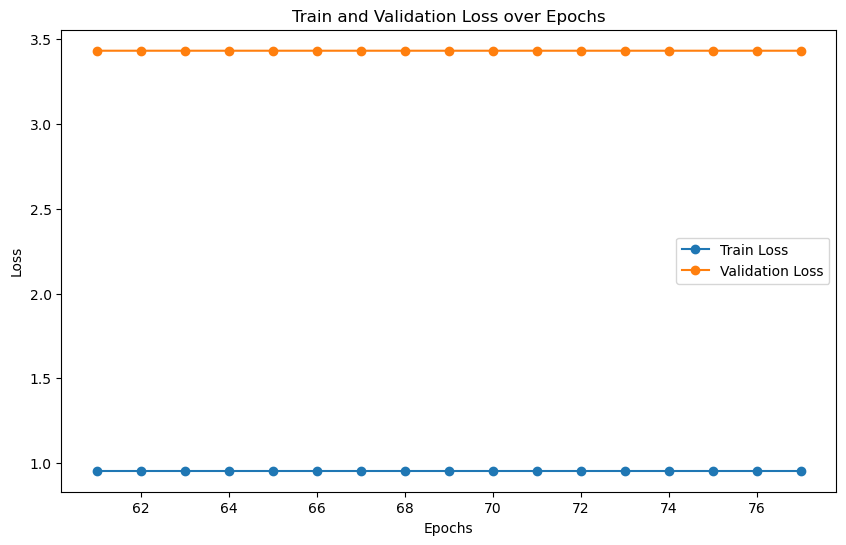

In [ ]:
# Filtrar
    # True , False
filtrar = True
max_value = 50
min_epoch = 60
max_epoch = 200

if(filtrar):
    train_loss_list_fil, val_loss_list_fil = filtrar_valores_listas(train_loss_list, val_loss_list, max_value, min_epoch, max_epoch)
    epochs_range = range(min_epoch + 1, min_epoch + 1 + len(train_loss_list_fil))
else:
    train_loss_list_fil, val_loss_list_fil = train_loss_list, val_loss_list
    epochs_range = range(1, len(train_loss_list_fil) + 1)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss_list_fil, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss_list_fil, label='Validation Loss', marker='o')
# Añadir títulos y etiquetas
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
val_loss_list

[6047.47998046875,
 1454.852783203125,
 2507.9619140625,
 727.7151489257812,
 122.9676284790039,
 22.515438079833984,
 6.497232437133789,
 3.7888944149017334,
 3.5250606536865234,
 3.4301979541778564,
 3.435793876647949,
 3.4271721839904785,
 3.428469657897949,
 3.426884412765503,
 3.426841974258423,
 3.4262335300445557,
 3.4259612560272217,
 3.4256420135498047,
 3.425337791442871,
 3.4249114990234375,
 3.424323320388794,
 3.4236772060394287,
 3.423154830932617,
 3.422767400741577,
 3.4224753379821777,
 3.422238826751709,
 3.4220261573791504,
 3.4218060970306396,
 3.4215056896209717,
 3.420971155166626,
 3.419898748397827,
 3.417781114578247,
 3.416790008544922,
 3.4170327186584473,
 3.417022466659546,
 3.4170894622802734,
 3.4171175956726074,
 3.4171571731567383,
 3.4171910285949707,
 3.417226552963257,
 3.417262315750122,
 3.417296886444092,
 3.417332887649536,
 3.4173667430877686,
 3.4174020290374756,
 3.417436122894287,
 3.4174704551696777,
 3.4175031185150146,
 3.417536497116089,


## Save model

In [ ]:
drive = False
if (drive):
    save_model_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:12]}.pth'
    results_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:12]}.pth'
else:
    save_model_path = os.path.join(main_dir, "models", f'model-{generate_id()[:12]}.pth')
    results_path = os.path.join(main_dir, "results", f'results-{generate_id()[:12]}.json')

print(save_model_path)
print(results_path)

/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/models/model-202407042057.pth
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202407042057.json


In [ ]:
#torch.save(model.state_dict(), save_model_path)

# Crear un diccionario con las listas
data = {
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'MAE': f"{MAE:.4f}",
    'MAPE': f"{MAPE:.2f}%",
    'RMSE': f"{RMSE:.4f}",
}

# Escribir el diccionario en un archivo JSON
with open(results_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

# Load Best Model

In [ ]:
model_id = 202407032036
# 202407012024

drive = False
if (drive):
    load_path = f'/content/drive/My Drive/TFM/models/model-{model_id}.pth'
else:
    load_path = os.path.join(main_dir, "models", f'model-{model_id}.pth')

print(load_path)

model = STGCN(Ks, Kt, blocks, n_his, n_route, Lk, drop_prob).to(device)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict)
type(model)

/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/models/model-202407032036.pth


__main__.STGCN

# Prediction

In [ ]:
model.eval()

with torch.no_grad():
    mae, mape, mse = [], [], []
    for x, y in test_iter:
        x_raw = x
        y_raw = y
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)


In [ ]:
def search_value_in_dataframe(df, value):

    result = []
    for col in df.columns:
        matching_rows = df[df[col] == value].index.tolist()
        for row in matching_rows:
            result.append((row, col))
    return result

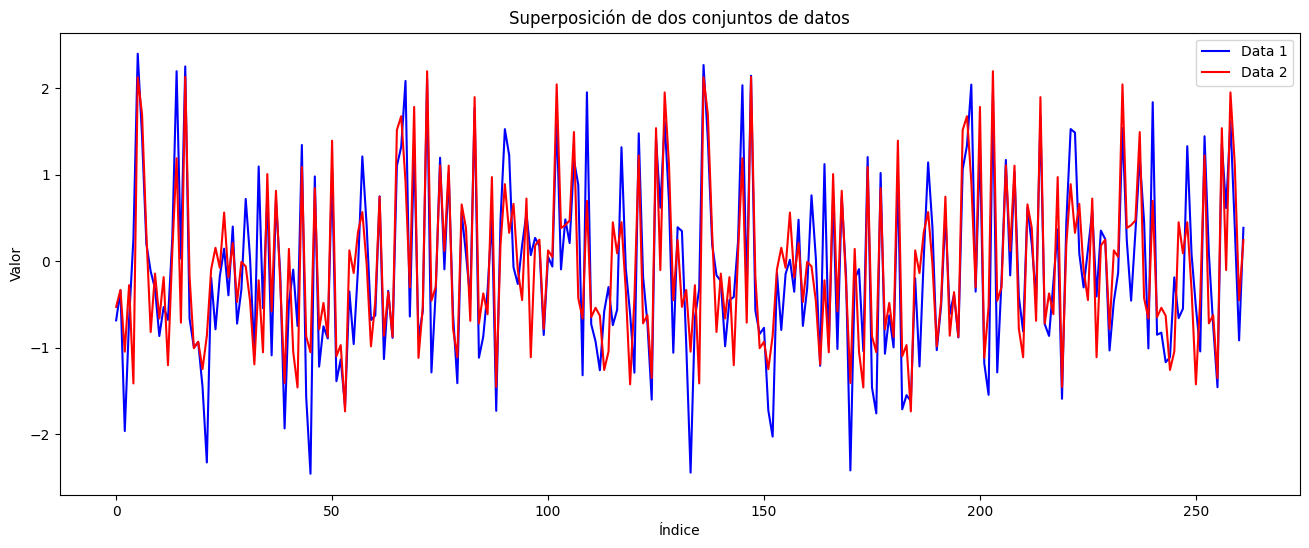

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes dos numpy arrays de ejemplo
data1 = y
data2 = y_pred

# Crear una figura y un conjunto de ejes
plt.figure(figsize=(16, 6))

# Graficar el primer conjunto de datos
plt.plot(data1, label='Data 1', color='b')

# Superponer el segundo conjunto de datos
plt.plot(data2, label='Data 2', color='r')

# Añadir título y etiquetas
plt.title('Superposición de dos conjuntos de datos')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
len(y)

262

### predicts 2020

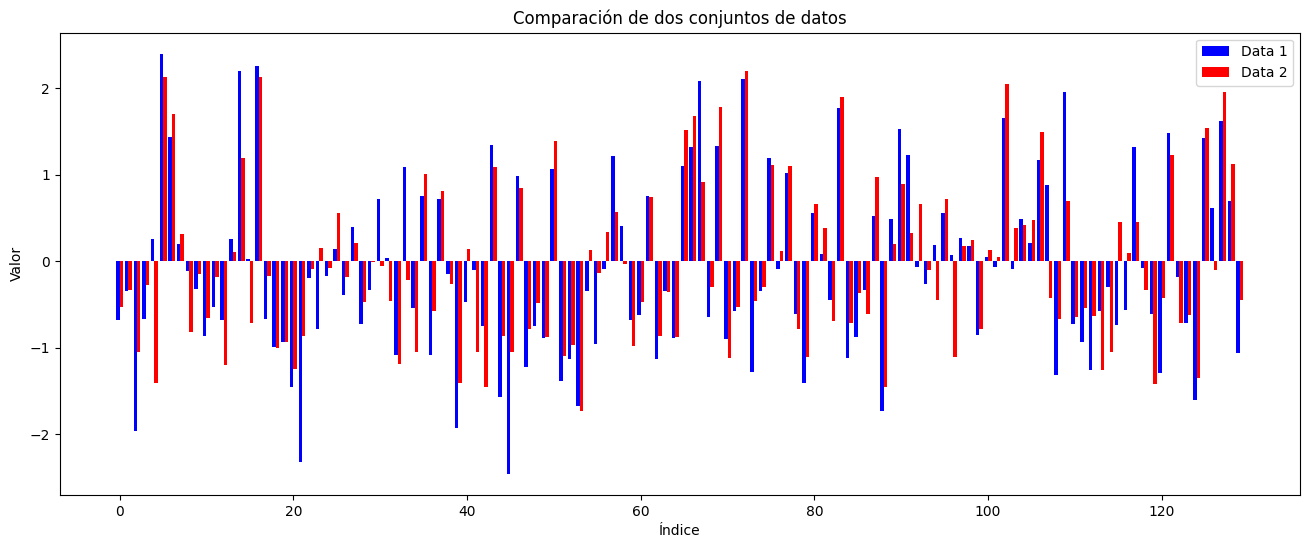

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes dos numpy arrays de ejemplo
data1 = y[:130]  # Ejemplo de datos aleatorios
data2 = y_pred[:130]  # Ejemplo de datos aleatorios

# Crear una figura y un conjunto de ejes
plt.figure(figsize=(16, 6))

# Definir el índice para las barras
indices = np.arange(len(data1))

# Ancho de las barras
width = 0.4

# Graficar el primer conjunto de datos como barras
plt.bar(indices - width/2, data1, width=width, label='Data 1', color='blue')

# Graficar el segundo conjunto de datos como barras
plt.bar(indices + width/2, data2, width=width, label='Data 2', color='red')

# Añadir título y etiquetas
plt.title('Comparación de dos conjuntos de datos')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
list(matrix_df.columns)[2]

'ALB'

In [ ]:
list(matrix_df.columns)[61]

'IRQ'

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1[:130] - data2[:130])

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"La posición con la mayor diferencia es: {posicion_max_diferencia}")
print(f"La mayor diferencia es: {mayor_diferencia}")
varianza = np.var(data_df['ALB'])
varianza

La posición con la mayor diferencia es: 4
La mayor diferencia es: 1.6713793277740479


0.061128118061207194

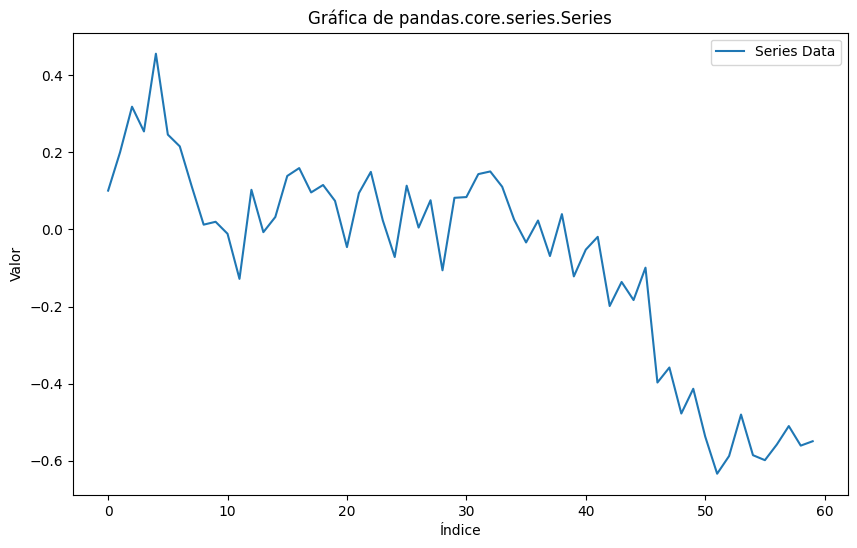

In [ ]:
type(data_df['AUS'])

plt.figure(figsize=(10, 6))
plt.plot(data_df['AUS'], label='Series Data')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfica de pandas.core.series.Series')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la mayor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La mayor diferencia es: {mayor_diferencia}")


El pais con la mayor diferencia es: AUS
La mayor diferencia es: 1.6713793277740479


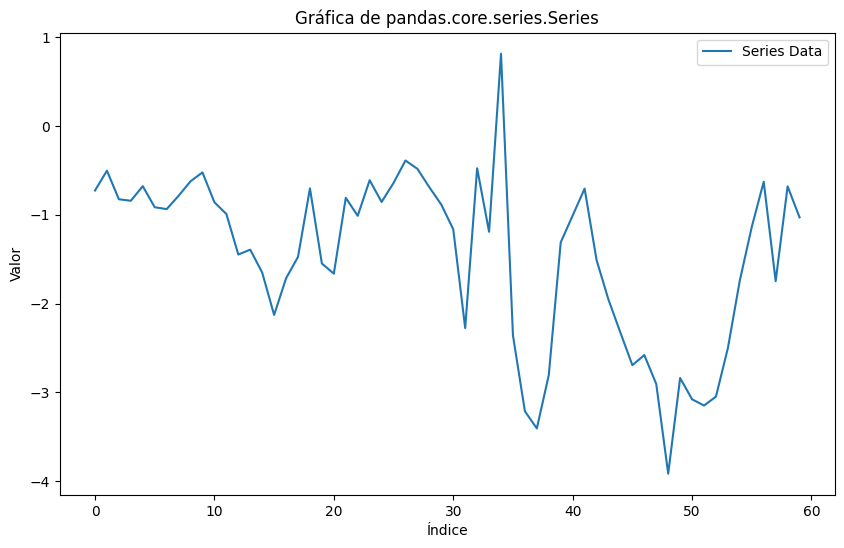

In [ ]:
type(data_df['IRQ'])

plt.figure(figsize=(10, 6))
plt.plot(data_df['IRQ'], label='Series Data')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfica de pandas.core.series.Series')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
data_df = pd.read_csv(data_path)

In [ ]:
data = data.drop(columns=['year'])

In [ ]:
y_1 = y[:131]
y_2 = y[131:]

y_pred_1 = y_pred[:131]
y_pred_2 = y_pred[:131]

In [ ]:
results_2020 = pd.DataFrame([y_1, y_pred_1], columns=data.columns)
results_2021 = pd.DataFrame([y_2, y_pred_2], columns=data.columns)

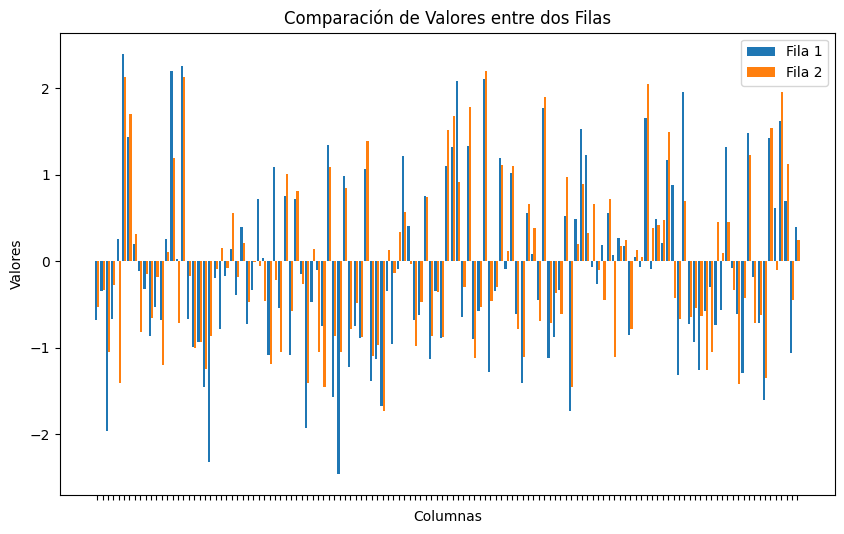

In [ ]:
fila_1 = results_2020.iloc[0]  # Primera fila
fila_2 = results_2020.iloc[1]  # Segunda fila

# Configurar los valores de las dos filas
valores_fila_1 = fila_1.values
valores_fila_2 = fila_2.values

labels = fila_1.index

# Crear la gráfica de barras
x = range(len(labels))
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
ax.bar(x, valores_fila_1, width=width, label='Fila 1', align='center')
ax.bar([p + width for p in x], valores_fila_2, width=width, label='Fila 2', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Columnas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Valores entre dos Filas')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels([''] * len(labels))  # Configurar las etiquetas del eje x como vacías
ax.legend()

# Mostrar la gráfica
plt.show()


### predicts 2021

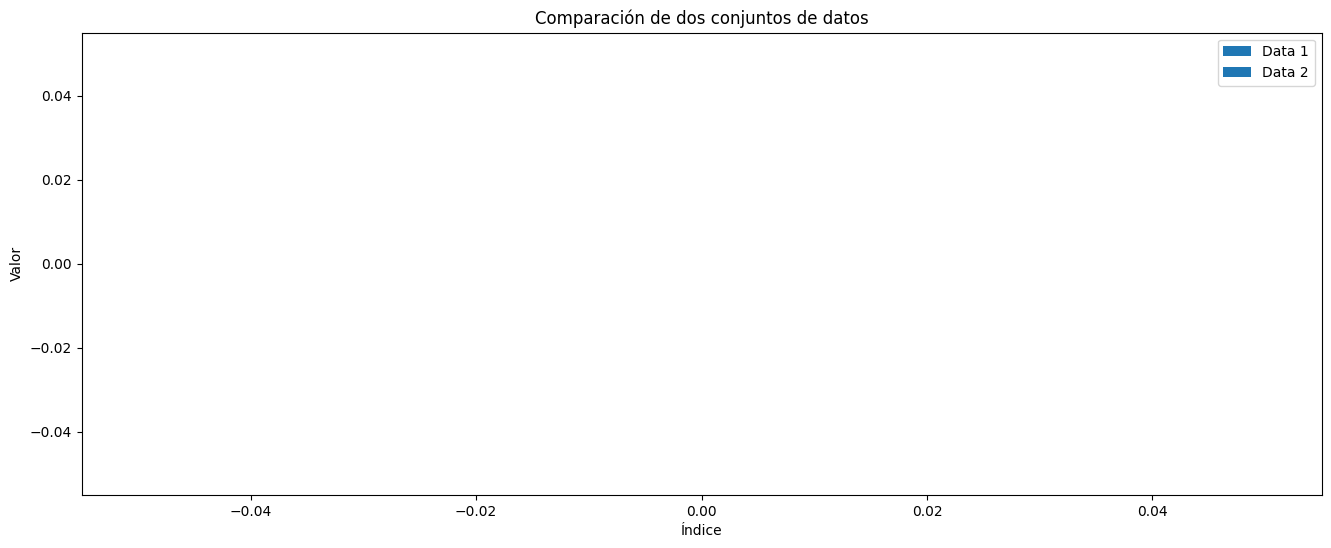

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes dos numpy arrays de ejemplo
data1 = y[131:]  # Ejemplo de datos aleatorios
data2 = y_pred[131:]  # Ejemplo de datos aleatorios

# Crear una figura y un conjunto de ejes
plt.figure(figsize=(16, 6))

# Definir el índice para las barras
indices = np.arange(len(data1))

# Ancho de las barras
width = 0.4

# Graficar el primer conjunto de datos como barras
plt.bar(indices - width/2, data1, width=width, label='Data 1', color='b')

# Graficar el segundo conjunto de datos como barras
plt.bar(indices + width/2, data2, width=width, label='Data 2', color='r')

# Añadir título y etiquetas
plt.title('Comparación de dos conjuntos de datos')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
list(matrix_df.columns)[4]

'AUS'

In [ ]:
data1 = y[131:]
data2 = y_pred[131:]

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la mayor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La mayor diferencia es: {mayor_diferencia}")
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])}")

El pais con la mayor diferencia es: ALB
La mayor diferencia es: 1.3962376117706299
Varianza de ALB : 0.061128118061207194


In [ ]:
varianza = np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {}")

0.061128118061207194

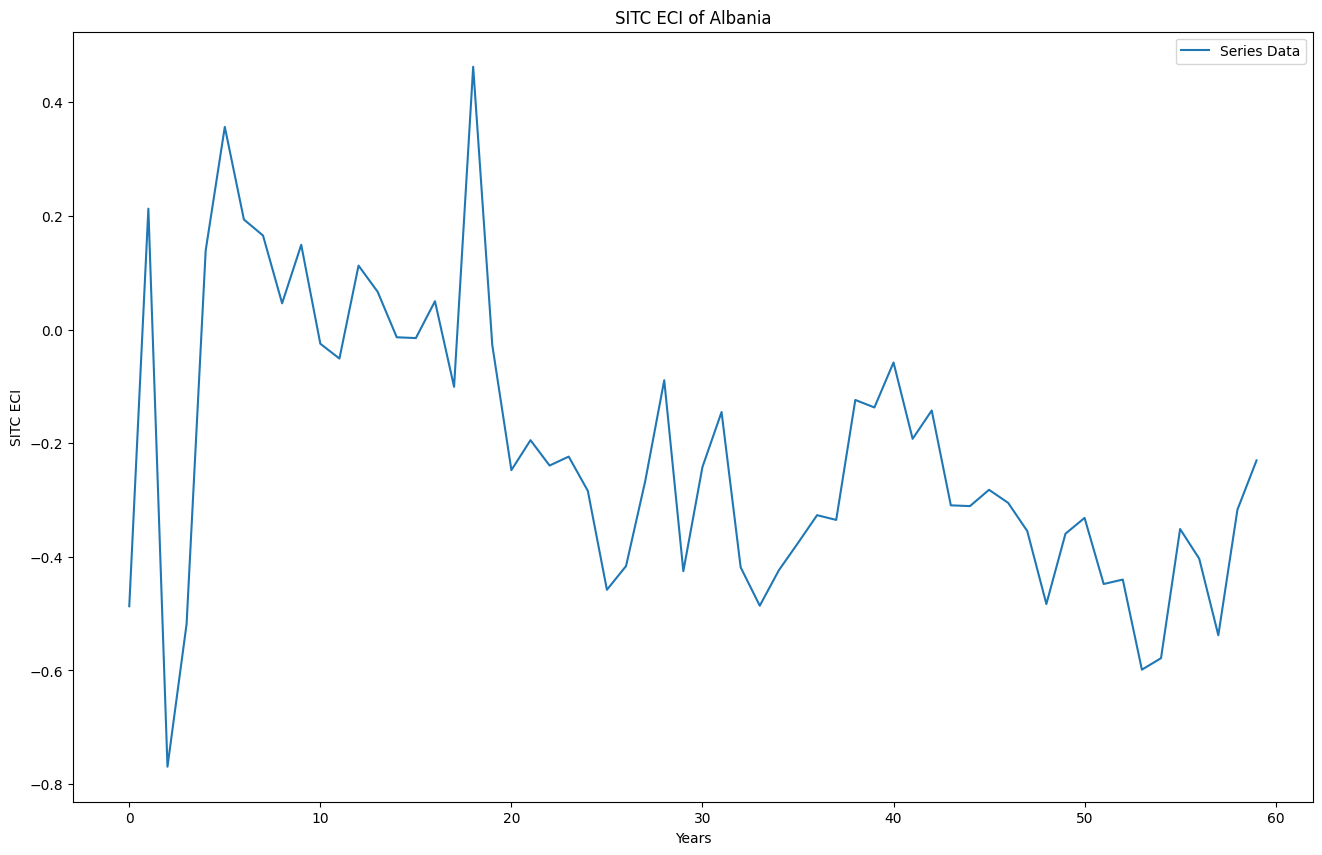

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(data_df['ALB'], label='Series Data')
plt.xlabel('Years')
plt.ylabel('SITC ECI')
plt.title('SITC ECI of Albania')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmin(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la menor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La menor diferencia es: {mayor_diferencia}")
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])}")

El pais con la menor diferencia es: PHL
La menor diferencia es: 0.0067242830991744995
Varianza de PHL : 0.12285973089026177


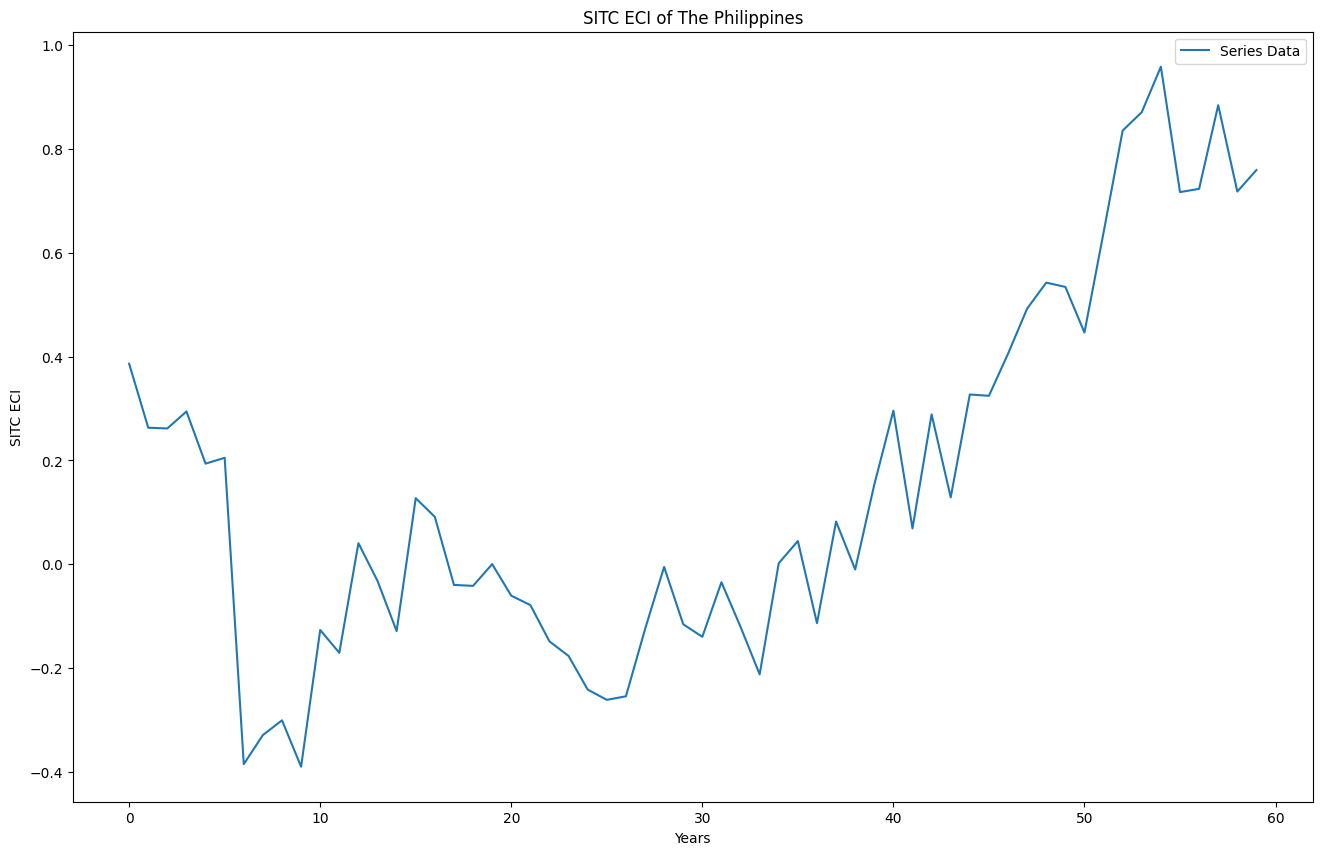

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(data_df['PHL'], label='Series Data')
plt.xlabel('Years')
plt.ylabel('SITC ECI')
plt.title('SITC ECI of The Philippines')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
data_df = pd.read_csv(data_path)

In [ ]:
data = data.drop(columns=['year'])

In [ ]:
y_1 = y[:131]
y_2 = y[131:]

y_pred_1 = y_pred[:131]
y_pred_2 = y_pred[:131]

In [ ]:
results_2020 = pd.DataFrame([y_1, y_pred_1], columns=data.columns)
results_2021 = pd.DataFrame([y_2, y_pred_2], columns=data.columns)

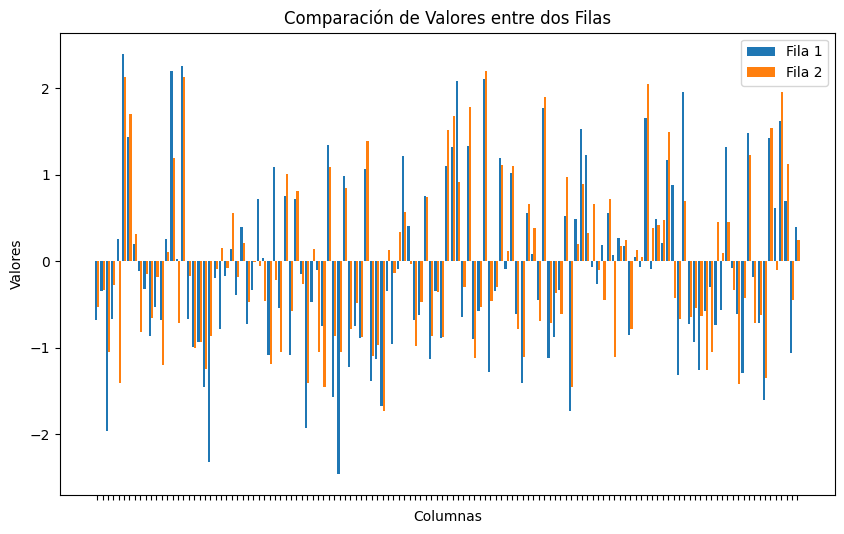

In [ ]:
fila_1 = results_2020.iloc[0]  # Primera fila
fila_2 = results_2020.iloc[1]  # Segunda fila

# Configurar los valores de las dos filas
valores_fila_1 = fila_1.values
valores_fila_2 = fila_2.values

labels = fila_1.index

# Crear la gráfica de barras
x = range(len(labels))
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
ax.bar(x, valores_fila_1, width=width, label='Fila 1', align='center')
ax.bar([p + width for p in x], valores_fila_2, width=width, label='Fila 2', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Columnas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Valores entre dos Filas')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels([''] * len(labels))  # Configurar las etiquetas del eje x como vacías
ax.legend()

# Mostrar la gráfica
plt.show()


### countries study

In [ ]:
matrix_columns = list(matrix_df.columns)

In [ ]:
def n_closest_countries(df, country, N):
    distances = df[country]
    sorted_distances = distances.sort_values()
    closest_indices = sorted_distances.index[1:N+1]  # Skip the first one as it is the country itself
    closest_countries = [matrix_columns[i] for i in closest_indices]
    return closest_countries

def n_farthest_countries(df, country, N):
    distances = df[country]
    sorted_distances = distances.sort_values(ascending=False)
    farthest_indices = sorted_distances.index[:N]
    farthest_countries = [matrix_columns[i] for i in farthest_indices]
    return farthest_countries

def calcular_varianza(df, columna, previous_n=60):
    varianza = df[columna][:previous_n].var()
    return varianza


In [ ]:
def get_data_countries(country_name, N=5):
    # Calcular la varianza para cada uno de los países más cercanos y calcular la media de estas varianzas
    closest_countries = n_closest_countries(matrix_df, country_name, N)
    varianzas = [calcular_varianza(data_df, country, 10) for country in closest_countries]
    media_varianzas = np.mean(varianzas)

    print(f"Los {N} países más cercanos a {country_name} son: {closest_countries}")
    print(f"La varianza de cada uno de estos paíse de los ultimos 10 años es: {[round(v, 4) for v in varianzas]}")
    print(f"La media de las varianzas es: {round(media_varianzas, 4)}")

    # Calcular la varianza para cada uno de los países más cercanos y calcular la media de estas varianzas
    farthest_countries = n_farthest_countries(matrix_df, country_name, N)
    varianzas = [calcular_varianza(data_df, country, 10) for country in farthest_countries]
    media_varianzas = np.mean(varianzas)

    print(f"Los {N} países más lejanos a {country_name} son: {farthest_countries}")
    print(f"La varianza de cada uno de estos países de los ultimos 10 años es: {[round(v, 4) for v in varianzas]}")
    print(f"La media de las varianzas es: {round(media_varianzas, 4)}")

    return closest_countries, farthest_countries

def represent_countries(countries, previous_n=10):
  # Filtrar las columnas más cercanas
  filtered_df = data_df[countries][:previous_n]

  # Crear la gráfica
  plt.figure(figsize=(14, 8))

  # Graficar cada columna
  for column in filtered_df.columns:
      plt.plot(filtered_df.index, filtered_df[column], label=column)

  # Añadir título y etiquetas
  plt.title('Valores de las columnas más cercanas')
  plt.xlabel('Índice')
  plt.ylabel('Valor')

  # Añadir una leyenda
  plt.legend()

  # Mostrar la gráfica
  plt.show()

In [ ]:
closest_countries, farthest_countries = get_data_countries('ALB')

Los 5 países más cercanos a ALB son: ['GRC', 'BGR', 'ITA', 'HUN', 'MLT']
La varianza de cada uno de estos paíse de los ultimos 10 años es: [0.0425, 0.0348, 0.0026, 0.0094, 0.006]
La media de las varianzas es: 0.0191
Los 5 países más lejanos a ALB son: ['NZL', 'WSM', 'FJI', 'NCL', 'VUT']
La varianza de cada uno de estos países de los ultimos 10 años es: [0.0042, 0.1646, 0.1128, 0.1446, 0.0482]
La media de las varianzas es: 0.0949


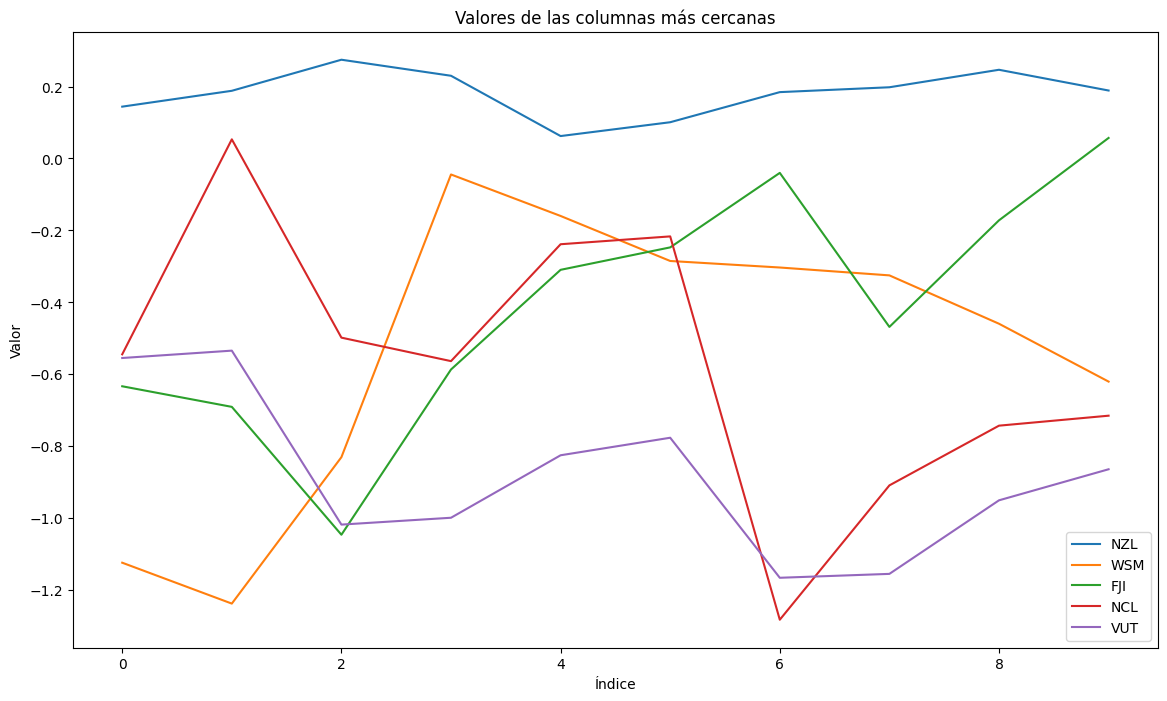

In [ ]:
represent_countries(farthest_countries)

# Comparación modelos

## Load results

In [ ]:
regular_data = "results-20240630"
inverted_matrix = "results-20240701"

results_main_path = '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results'

### List files

In [ ]:
import os

def list_files(carpeta, prefijo):
    # Lista para almacenar los paths de los archivos que cumplen con el criterio
    archivos_filtrados = []

    # Iterar sobre los archivos en la carpeta
    for archivo in os.listdir(carpeta):
        # Comprobar si el archivo comienza con el prefijo especificado
        if archivo.startswith(prefijo):
            # Crear el path completo del archivo y añadirlo a la lista
            path_completo = os.path.join(carpeta, archivo)
            archivos_filtrados.append(path_completo)

    return archivos_filtrados

result_list = list_files(results_main_path, regular_data)

# Imprimir los paths de los archivos que cumplen con el criterio
for result_file in result_list:
    print(result_file)


/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301155.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301204.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301208.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301214.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301220.json


In [ ]:
results_dict = {
    "AdamW - CosineAnnealingLR": result_list[0],
    "RMSprop - CosineAnnealingLR": result_list[1],
    "AdamW -CosineAnnealingLR": result_list[2],
    "AdamW -CosineAnnealingLR": result_list[3],
}

['/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301155.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301204.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301208.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301214.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301220.json']

### Enum files and search

In [ ]:
def leer_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def leer_result(file_path):
    file_path = f'{results_main_path}/results-{file_path}.json'
    return leer_json(file_path)

def get_results_data(model_dict):
    for key, value in model_dict.items():
        # Leer el archivo JSON correspondiente usando el "id"
        json_data = leer_result(value["id"])

        # Añadir los datos del JSON al diccionario bajo la misma clave
        model_dict[key].update(json_data)

    return model_dict

In [ ]:
regular_data_dict = {
    0: {"name": "AdamW - CosineAnnealingLR", "id": 202407032033},
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407042014},
    2: {"name": "RMSprop - StepLR", "id": 202407032036},
    3: {"name": "AdamW - StepLR", "id": 202407032034},
}

inverted_matrix_dict = {
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407032058},
    2: {"name": "RMSprop - StepLR", "id": 202407032056},
}

exp_inverted_matrix_dict = {
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407032106},
    2: {"name": "RMSprop - StepLR", "id": 202407032107},
}

## Grafico

In [ ]:
results_data = get_results_data(regular_data_dict)

regular_result_loss = leer_result('202407042014')['val_loss_list']
inverted_result_loss = leer_result('202407032058')['val_loss_list']
exp_inverted_result_loss = leer_result('202407032106')['val_loss_list']
exp_inverted_loss_expanded = leer_result('202407042053')['val_loss_list']
exp_inverted_loss_expanded_v2 = leer_result('202407042053')['val_loss_list']

### Listas de loss

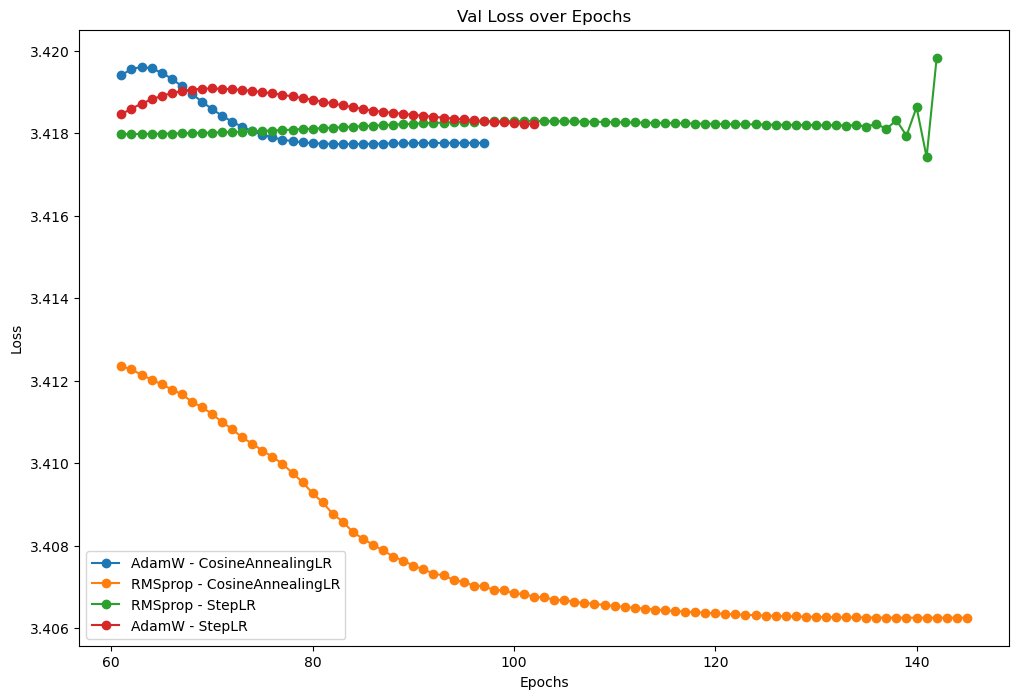

In [ ]:
# Filtrar
    # True | False
filtrar = True
max_value = 3.5
min_epoch = 60
max_epoch = 200
# 'train_loss_list' | 'val_loss_list'
loss_list_name = 'val_loss_list'

# Crear la gráfica
plt.figure(figsize=(12, 8))

for key, value in results_data.items():
    loss_list = value[loss_list_name]

    if(filtrar):
        loss_list_fil = filtrar_valores_lista(loss_list, max_value, min_epoch, max_epoch)
        epochs_range = range(min_epoch + 1, min_epoch + 1 + len(loss_list_fil))
    else:
        loss_list_fil = loss_list
        epochs_range = range(1, len(loss_list_fil) + 1)

    name = value['name']
    plt.plot(epochs_range, loss_list_fil, label=name, marker='o')

# Añadir títulos y etiquetas
plt.title('Val Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Métricas

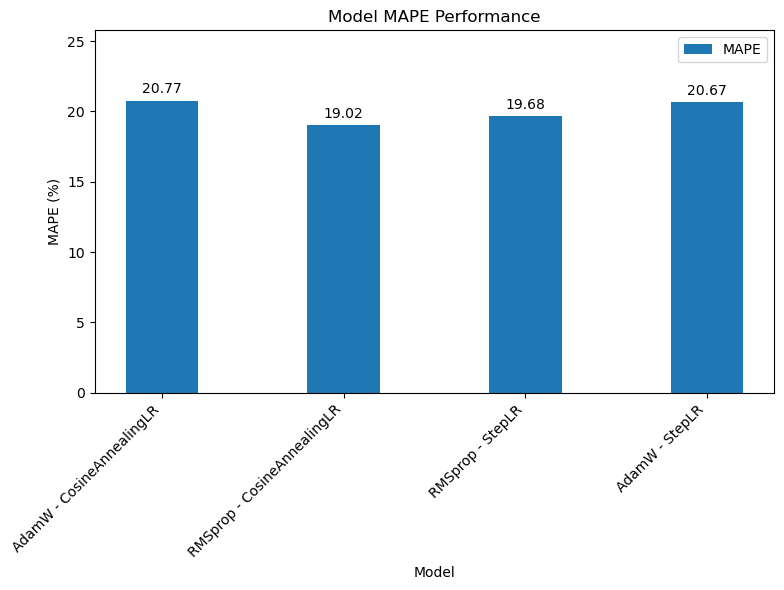

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recopilar los valores de MAPE
model_names = []
mape_values = []

for key, value in results_data.items():
    model_names.append(value['name'])
    mape_values.append(float(value['MAPE'].strip('%')))

# Configurar la posición de las barras
x = np.arange(len(model_names))
width = 0.4  # Ancho de las barras

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 6))

# Añadir las barras para MAPE
rects = ax.bar(x, mape_values, width, label='MAPE')

# Añadir etiquetas y títulos
ax.set_xlabel('Model')
ax.set_ylabel('MAPE (%)')
ax.set_title('Model MAPE Performance')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Ajustar el límite superior del eje y para dar más margen
max_height = max(mape_values)
ax.set_ylim(0, max_height + 5)  # Añade un margen del 5% sobre el valor máximo

# Añadir los valores encima de las barras
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


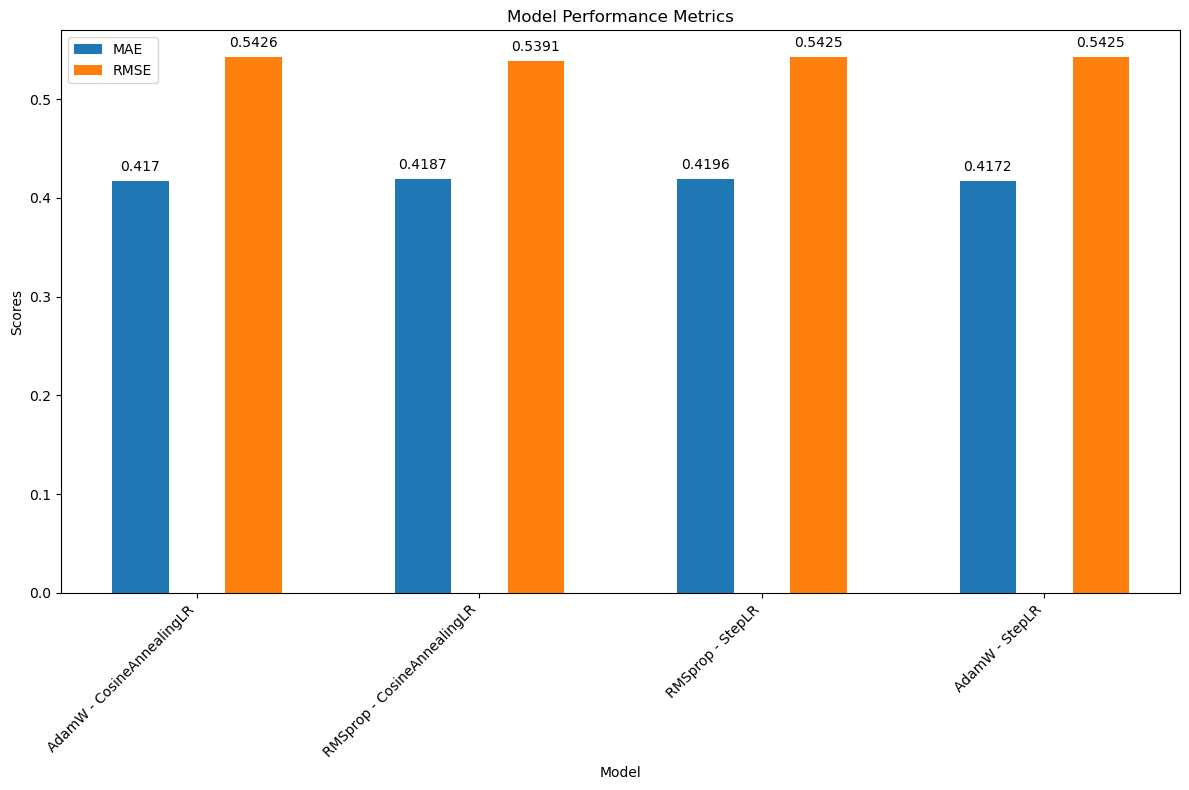

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recopilar los valores de MAE, MAPE y RMSE
model_names = []
mae_values = []
mape_values = []
rmse_values = []

for key, value in results_data.items():
    model_names.append(value['name'])
    mae_values.append(float(value['MAE']))
    rmse_values.append(float(value['RMSE']))

# Configurar la posición de las barras
x = np.arange(len(model_names))
width = 0.2  # Ancho de las barras

# Crear la gráfica
fig, ax = plt.subplots(figsize=(12, 8))

# Añadir las barras para MAE, MAPE y RMSE
rects1 = ax.bar(x - width, mae_values, width, label='MAE')
rects3 = ax.bar(x + width, rmse_values, width, label='RMSE')

# Añadir etiquetas y títulos
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Añadir los valores encima de las barras
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 5)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects3)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


### All data types

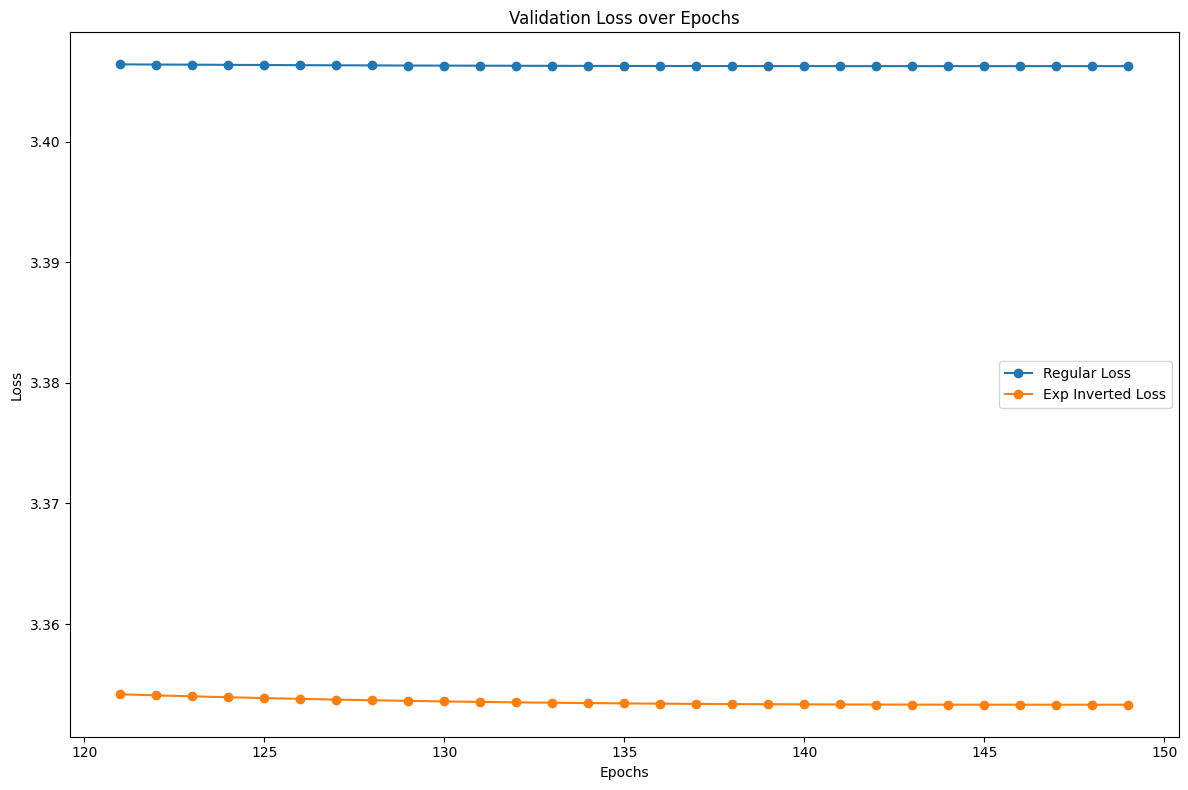

In [ ]:
# Parámetros de filtrado
# False | True
filtrar = True
max_value = 1000
min_epoch = 10
max_epoch = 150

# Filtrar las listas de resultados si es necesario
if filtrar:
    regular_result_loss_fil = filtrar_valores_lista(regular_result_loss, max_value, min_epoch, max_epoch)
    inverted_result_loss_fil = filtrar_valores_lista(inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_result_loss_fil = filtrar_valores_lista(exp_inverted_result_loss, max_value, min_epoch, max_epoch)
else:
    regular_result_loss_fil = regular_result_loss
    inverted_result_loss_fil = inverted_result_loss
    exp_inverted_result_loss_fil = exp_inverted_result_loss

# Crear rangos de épocas correspondientes
epochs_range_regular = range(min_epoch + 1, min_epoch + 1 + len(regular_result_loss_fil))
# epochs_range_inverted = range(min_epoch + 1, min_epoch + 1 + len(inverted_result_loss_fil))
epochs_range_exp_inverted = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_result_loss_fil))

# Crear la gráfica
plt.figure(figsize=(12, 8))

# Plotear los resultados
plt.plot(epochs_range_regular, regular_result_loss_fil, label='Regular Loss', marker='o')
# plt.plot(epochs_range_inverted, inverted_result_loss_fil, label='Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted, exp_inverted_result_loss_fil, label='Exp Inverted Loss', marker='o')

# Añadir títulos y etiquetas
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
exp_inverted_loss_expanded = exp_inverted_loss_expanded_fil
exp_inverted_loss_expanded_v2 = val_loss_list

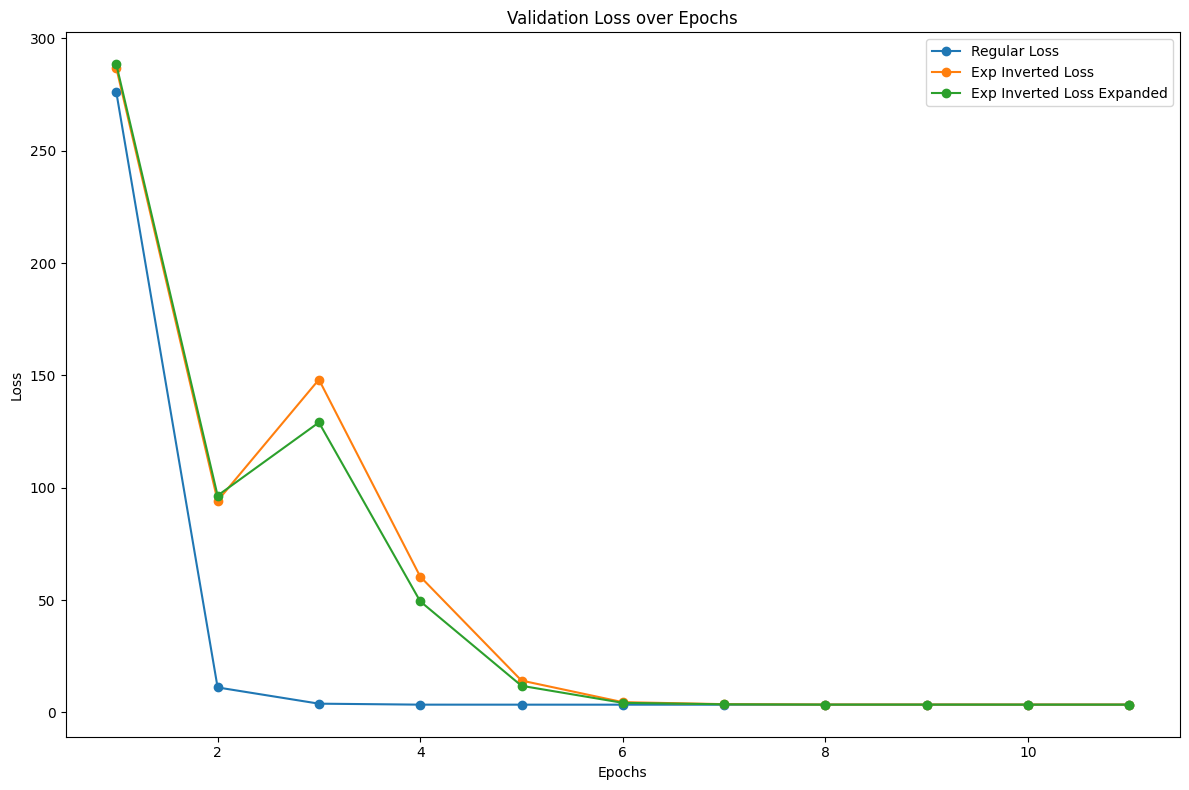

In [ ]:
# False | True
filtrar = True
max_value = 300
min_epoch = 0
max_epoch = 10

# Filtrar las listas de resultados si es necesario
if filtrar:
    regular_result_loss_fil = filtrar_valores_lista(regular_result_loss, max_value, min_epoch, max_epoch)
    # inverted_result_loss_fil = filtrar_valores_lista(inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_result_loss_fil = filtrar_valores_lista(exp_inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_loss_expanded_fil = filtrar_valores_lista(exp_inverted_loss_expanded, max_value, min_epoch, max_epoch)
    # exp_inverted_loss_expanded_v2_fil = filtrar_valores_lista(exp_inverted_loss_expanded_v2, max_value, min_epoch, max_epoch)
else:
    regular_result_loss_fil = regular_result_loss
    # inverted_result_loss_fil = inverted_result_loss
    exp_inverted_result_loss_fil = exp_inverted_result_loss
    exp_inverted_loss_expanded_fil = exp_inverted_loss_expanded
    # exp_inverted_loss_expanded_v2_fil = exp_inverted_loss_expanded_v2

# Crear rangos de épocas correspondientes
epochs_range_regular = range(min_epoch + 1, min_epoch + 1 + len(regular_result_loss_fil))
# epochs_range_inverted = range(min_epoch + 1, min_epoch + 1 + len(inverted_result_loss_fil))
epochs_range_exp_inverted = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_result_loss_fil))
epochs_range_exp_inverted_expanded = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_loss_expanded_fil))
# epochs_range_exp_inverted_expanded_v2 = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_loss_expanded_v2_fil))

# Crear la gráfica
plt.figure(figsize=(12, 8))

# Plotear los resultados
plt.plot(epochs_range_regular, regular_result_loss_fil, label='Regular Loss', marker='o')
# plt.plot(epochs_range_inverted, inverted_result_loss_fil, label='Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted, exp_inverted_result_loss_fil, label='Exp Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted_expanded, exp_inverted_loss_expanded_fil, label='Exp Inverted Loss Expanded', marker='o')
# plt.plot(epochs_range_exp_inverted_expanded_v2, exp_inverted_loss_expanded_v2_fil, label='Exp Inverted Loss 500', marker='o')

# Añadir títulos y etiquetas
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### Data Explore

In [ ]:
# Ejemplo de matriz de distancias 2x2
distances = np.array([[1000, 8, 2],
                      [1, 3, 90]])

# Llamar a la función calculate_adjacency_matrix con la matriz de distancias de ejemplo
adjacency_matrix = calculate_adjacency_matrix(distances, sigma_squared=10, epsilon=0.5)

# Imprimir la matriz de adyacencia resultante
adjacency_matrix

array([[0.        , 0.        ],
       [0.90483742, 0.        ]])

In [ ]:
def search_value_in_dataframe(df, value):

    result = []

    for col in df.columns:
        matching_rows = df[df[col] == value].index.tolist()
        for row in matching_rows:
            result.append((row, col))
    return result

In [ ]:
data = pd.read_csv(data_path)
data.head()

,year,COM,GUY,LBR,SEN,BRN,JPN,USA,RUS,OMN,...,IRL,SUR,BEN,COG,FIN,TUR,GBR,NOR,NIC,CYP
0,1962,-0.344110,0.068288,-0.442236,-0.203830,0.193716,2.091124,2.072395,0.535564,0.003049,...,1.172661,-0.182548,0.062017,-0.865575,1.125539,-0.704393,2.288769,1.365959,-1.075753,0.000652
1,1963,-0.138500,-0.112739,-0.764035,-0.198813,-1.363110,1.917151,2.034126,0.316475,0.837160,...,1.008410,-0.267773,0.264796,-0.654586,1.375939,-0.769430,2.278447,1.231053,-1.057869,-0.131323
2,1964,-1.421275,-0.130738,-0.604106,-0.484891,-0.469227,1.895972,2.039541,0.726326,-0.868269,...,1.194336,-0.909445,0.085699,-1.230536,1.293779,-0.601434,2.227930,1.321681,-0.222088,-0.344254
3,1965,-1.312219,-0.209335,-0.565352,-0.422038,-1.309534,1.944695,2.066791,0.723283,-0.834009,...,1.258328,-0.280529,-0.100788,-0.824339,1.331217,-0.715468,2.347121,1.216481,0.143597,-0.492979
4,1966,-1.334038,-0.376698,-0.523193,-0.147933,-0.461554,1.881980,2.018157,0.638421,-0.669928,...,1.140344,-0.320551,-0.284729,-1.181578,1.468790,-0.682230,2.279568,1.301043,0.177704,-0.234378


In [ ]:
x_train_expl, y_train_expl = data_transform_explore(train_df, n_his, n_pred, device)
x_val_expl, y_val_expl = data_transform_explore(val_df, n_his, n_pred, device)
x_test_expl, y_test_expl = data_transform_explore(test_df, n_his, n_pred, device)

#### Train

In [ ]:
print(f'x_train size: {x_train_expl.shape}')
print(f'y_train size: {y_train_expl.shape}')

x_train size: torch.Size([24, 1, 10, 131])
y_train size: torch.Size([24, 131])


In [ ]:
search_value_in_dataframe(data, x_train_expl[23][0][0][0].item())

[(23, 'COM')]

In [ ]:
y_train_expl[0][0].item()

-0.20733918

In [ ]:
search_value_in_dataframe(data, y_train_expl[0][0].item())

[(11, 'COM')]